In [26]:
import numpy as np
import torch

# plt.ion()

In [27]:
# setup matplotlib
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    SAVE_PLOTS = False
else:
    matplotlib.use('Agg')
    SAVE_PLOTS = True
import matplotlib.pyplot as plt

In [28]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics, plot_metrics
from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
from tools.notify import notify
time_expector = TimeExpector()

In [29]:
BATCH_SIZE = 64
EPOHCS = 2
DATASET_CACHE_FOLDER_PATH = "storage/dvs/cache"
histogram_memory_size = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print("Device:", device)

Device: cpu


In [30]:
# def load_data(trail):
#     if trail.startswith('acc'):
#         max_augmentation = 1
#         augmentation = False
#     else:
#         max_augmentation = 2 if trail == 'train' else 1
#         augmentation = True
    
#     trail = trail.replace('acc_', '')
#     return batchify(
#         trail,
#         DATASET_FOLDER_PATH,
#         CACHE_FOLDER_PATH,
#         condition_limit=['natural'],
#         batch_size=batch_size,
#         augmentation=augmentation,
#         max_augmentation=max_augmentation,
#         frame=nb_frame
#     )

In [31]:
from random import randint
from data.cache_generator import data_loader, GESTURE_MAPPING

# def data_augment(*args, **kwargs):
#     max_augmentation = kwargs.pop('max_augmentation', 1)
#     aug_enabled = kwargs.pop('augmentation', True)
#     aug_x_offset = kwargs.pop('aug_x_offset', 10)
#     aug_y_offset = kwargs.pop('aug_y_offset', 3)
#     aug_frame_offset = kwargs.pop('aug_f_offset', 10)
#     frame = kwargs.pop('frame', 100)
#     all_frame_y = kwargs.pop('all_frame_y', False)

#     for data_x, data_y in data_loader(*args, **kwargs):
#         label_histogram = {i: 0 for i in GESTURE_MAPPING.keys()}
#         max_hist = None
#         output_x = []
#         output_y = []

#         last_label = None
#         buffer_x = []
#         buffer_y = []

#         # here we augment data until all classes have the same amount of data
#         while max_hist is None or any([i < max_hist for _, i in label_histogram.items()]):
#             if aug_enabled and max_hist is not None:
#                 x_offset = randint(-aug_x_offset, aug_x_offset)
#                 y_offset = randint(-aug_y_offset, aug_y_offset)
#                 frame_offset = randint(0, aug_frame_offset)
#             else:
#                 x_offset = 0
#                 y_offset = 0
#                 frame_offset = 0

#             for i in range(frame_offset, data_x.shape[0]):
#                 current_x = np.reshape(data_x[i], (64, 64))
#                 current_y = data_y[i]

#                 # image augmentation
#                 current_x = np.roll(current_x, x_offset, axis=0)
#                 current_x = np.roll(current_x, y_offset, axis=1)

#                 if last_label is None:
#                     last_label = current_y
#                 elif len(buffer_x) >= frame:
#                     if max_hist is None or label_histogram[current_y] < max_hist:
#                         output_x.append(np.array(buffer_x))
#                         output_y.append(np.array(buffer_y) if all_frame_y else current_y)
#                         label_histogram[current_y] += 1
#                     buffer_x = []
#                     buffer_y = []
#                 elif last_label != current_y:
#                     buffer_x = []
#                     buffer_y = []
#                     last_label = current_y
#                 buffer_x.append(current_x)
#                 buffer_y.append(current_y)

#             # if the augmentation is false, then we ignore adding any more data
#             if not aug_enabled:
#                 break

#             if max_hist is None:
#                 max_hist = label_histogram[max(label_histogram, key=label_histogram.get)] * max_augmentation

#         output_x = np.array(output_x)
#         output_y = np.array(output_y)

#         shuffle_indices = np.random.permutation(output_x.shape[0])
#         for i in shuffle_indices:
#             yield output_x[i, ...], output_y[i]


In [32]:
# %matplotlib osx
# FRAME = 100
# plt.figure(0)
# plt.ion()
# plt.show()

# imager = 1
# img = np.zeros((64, 64))
# for x, y in data_augment('test', DATASET_CACHE_FOLDER_PATH, DATASET_CACHE_FOLDER_PATH, frame=FRAME, condition_limit=['natural']):
#     for i in range(FRAME):
#         img *= 0.7
#         img += x[i, :, :]

#         plt.imshow(img, cmap='gray', vmin=0, vmax=1)
#         plt.draw()
#         plt.title('%d - %s' % (i, GESTURE_MAPPING[y]))
#         plt.pause(0.00001)
#         plt.clf()

#     if imager == 0:
#         break
#     imager -= 1
# print('done')

In [33]:
def stream_dataread(*args, **kwargs):
    batch_size = kwargs.pop('batch_size', 1)
    label_histogram = {i: 0 for i in GESTURE_MAPPING.keys()}
    for data_x, data_y in data_loader(*args, **kwargs):
        max_frames_duo_batch = int(data_x.shape[0] / batch_size)
        
        for i in range(max_frames_duo_batch):
            current_x = np.zeros((batch_size, 64, 64))
            current_y = np.zeros((batch_size, 1))
            
            for b in range(batch_size):
                current_x[b, :, :] = np.transpose(np.reshape(data_x[i+b*max_frames_duo_batch], (64, 64)))
                current_y[b, :] = data_y[i+b*max_frames_duo_batch]
                label_histogram[current_y[b, 0]] += 1

            yield current_x, current_y
            
        break #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<REMOVE THIS
        
# for x, y in stream_dataread('test', DATASET_CACHE_FOLDER_PATH, condition_limit=['natural'], batch_size=16):
#     print('x.shape:', x.shape)
#     print('y.shape:', y.shape)
#     break

In [52]:
def load_data(trail):
    if trail.startswith('acc_'):
        trail = trail.replace('acc_', '')
    
    max_frames = 1000
    
    for _xb, _yb in stream_dataread(
        trail,
        DATASET_CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=BATCH_SIZE
    ):
        yield _xb, _yb[:, 0]
        
        if max_frames <= 0:
            break
        else:
            max_frames -= 1


In [53]:
   
for xb, yb in load_data('train'):
    print(xb.shape)
    print(yb.shape)
    break

(64, 64, 64)
(64,)


In [36]:
# %matplotlib osx
# imager = 100
# img = np.zeros((64, 64))

# for x, y in load_data('test'):
#     imager -= 1
#     if imager < 0:
#         break

#     img = img * 0.9 + x[:, :] * 0.13
#     plt.imshow(img, cmap='gray', vmin=0, vmax=1)
#     plt.draw()
#     plt.title('%d - %s' % (imager, GESTURE_MAPPING[y]))
#     plt.pause(0.00001)
#     plt.clf()

In [37]:
# def batchify(*args, **kwargs):
#     batch_size = kwargs.pop('batch_size', 16)

#     batch_x = []
#     batch_y = []
#     for x, y in data_augment(*args, **kwargs):
#         batch_x.append(x)
#         batch_y.append(y)

#         if len(batch_x) >= batch_size:
#             yield np.array(batch_x), np.array(batch_y)
#             batch_x = []
#             batch_y = []



In [38]:
# original_size = 128
# for __xb, __yb in batchify(
#     'train',
#     DATASET_CACHE_FOLDER_PATH,
#     DATASET_CACHE_FOLDER_PATH,
#     condition_limit=['natural'],
#     batch_size=original_size,
#     augmentation=False,
#     max_augmentation=1,
#     frame=nb_frame,
#     all_frame_y=True
# ):
#     break
    
# _hist = {i:0 for i in range(12)}
# for i in __yb[:, 0]:
#     _hist[i] += 1
# max_value = max(_hist.values())

# aug_xb = []
# aug_yb = []
# for i in range(12):
#     idx = np.where(__yb[:, 0] == i)[0][0]
#     to_add = max_value - _hist[i]
#     for _ in range(to_add):
#         aug_yb.append(__yb[idx, :])
#         aug_xb.append(__xb[idx, :, :, :])

# print('pre augmentation size:')
# print(__xb.shape)
# print(__yb.shape)
# __yb = np.concatenate([__yb, np.array(aug_yb)])
# __xb = np.concatenate([__xb, np.array(aug_xb)])
# print('\npost augmentation size:')
# print(__xb.shape)
# print(__yb.shape)


# def load_data(trail):
#     begin = 0
#     end = begin + batch_size
#     while end <= __yb.shape[0]:
#         yield __xb[begin:end, :, :, :], __yb[begin:end]
#         begin = end
#         end = begin + batch_size

In [39]:
def plot_one_batch(network, batch_id=0):
    for X_batch, _ in load_data('train'):
        network.predict(X_batch)
        if network.network.layers[1].history_counter == 0:
            break

    for i,l in enumerate(network.network.layers):
        if 'spk_rec_hist' in l.__dict__:
            print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        plot_spikes_in_time(l, batch_id)

In [40]:
from matplotlib.gridspec import GridSpec
import seaborn as sns

def plot_spikes_in_time(layer, batch_id=0):
    if not layer.HAS_PARAM:
        return

    if layer.IS_CONV:
        _plot_spikes_conv(layer, batch_id)
    else:
        _plot_spikes_dense(layer, batch_id)


def _plot_spikes_dense(layer, batch_id=0):
    if 'mem_rec_hist' in layer.__dict__:
        mem_rec_hist = layer.mem_rec_hist[batch_id]
        for i in range(mem_rec_hist.shape[1]):
            plt.plot(mem_rec_hist[:, i], label='mem')
            if i > 30:
                break
        plt.xlabel('Time')
        plt.ylabel('Membrace Potential')
        plt.show()

    if 'spk_rec_hist' in layer.__dict__:
        spk_rec_hist = layer.spk_rec_hist[batch_id]
        plt.plot(spk_rec_hist, 'b.')
        plt.xlabel('Time')
        plt.ylabel('Spikes')
        plt.show()

        plt.matshow(spk_rec_hist)
        plt.xlabel('Neuron')
        plt.ylabel('Spike Time')
        plt.axis([-1, spk_rec_hist.shape[1], -1, spk_rec_hist.shape[0]])
        plt.show()



In [41]:
def _plot_spikes_conv(layer, batch_id=0):
    spk_rec_hist = layer.spk_rec_hist[batch_id]
    mem_rec_hist = layer.mem_rec_hist[batch_id]

    time_step = mem_rec_hist.shape[1]
    channels = mem_rec_hist.shape[0]
    rest_shape = mem_rec_hist.shape[2:]

    tmp_spk = np.zeros((time_step, channels, *rest_shape))
    tmp_mem = np.zeros((time_step, channels, *rest_shape))
    for i in range(time_step):
        tmp_spk[i, :, :, :] = spk_rec_hist[:, i, :, :]
        tmp_mem[i, :, :, :] = mem_rec_hist[:, i, :, :]
    spk_rec_hist = tmp_spk
    mem_rec_hist = tmp_mem

    flat_spk = np.reshape(spk_rec_hist, (time_step, channels * np.prod(mem_rec_hist.shape[2:])))
    flat_mem = np.reshape(mem_rec_hist, (time_step, channels * np.prod(mem_rec_hist.shape[2:])))

    # Plot Flats
    max_flats = 25
    if flat_mem.shape[1] > max_flats:
        inx = np.random.randint(flat_mem.shape[1], size=max_flats)
        flat_spk = flat_spk[:, inx]
        flat_mem = flat_mem[:, inx]

    for i in range(flat_mem.shape[1]):
        plt.plot(flat_mem[:, i], label='mem')
    plt.xlabel('Time')
    plt.ylabel('Membrace Potential')
    plt.show()

    plt.plot(flat_spk, '.')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.show()

    plt.matshow(flat_spk, cmap=plt.cm.gray_r, origin="upper", aspect='auto')
    plt.xlabel('Neuron')
    plt.ylabel('Spike Time')
    plt.axis([-1, flat_spk.shape[1], -1, flat_spk.shape[0]])
    plt.show()

    # Visual Plots
    max_visual = 5

    time_idx = list(range(0, time_step, int(time_step / max_visual)))
    neur_idx = np.random.randint(mem_rec_hist.shape[1], size=max_visual)

    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

    # Draw Time based mems
    counter = 0
    for n in neur_idx:
        for t in time_idx:
            if counter == 0:
                a0 = ax = plt.subplot(gs[counter])
            else:
                ax = plt.subplot(gs[counter], sharey=a0)
            ax.imshow(mem_rec_hist[t, n, :, :], cmap=plt.cm.gray_r, origin="upper", aspect='auto')
            plt.title('t(%d) - n(%d)' % (t, n))
            counter += 1
    plt.show()

    # Draw  Filters
    gs = GridSpec(3, 20)
    plt.figure(figsize=(10, 10))

    counter = 0
    for c_output in range(layer.output_channels):
        for c_input in range(layer.input_channels):
            if counter == 0:
                a0 = ax = plt.subplot(gs[counter])
            else:
                ax = plt.subplot(gs[counter], sharey=a0)
            ax.imshow(layer.w.detach().cpu().numpy()[c_output, c_input, :, :], cmap=plt.cm.gray_r, origin="upper", aspect='equal')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            # plt.title('in(%d) - out(%d)' % (t, n))
            counter += 1

            if counter >= 60:
                break
        if counter >= 60:
            break
    plt.show()



In [42]:
from scnn import SNN

In [43]:
# import torch
# import numpy as np

# import json
# from time import time
# from datetime import datetime
# from os import path
# from os import walk

# from scnn.heaviside import SurrogateHeaviside

# from scnn.default_configs import *

In [44]:
# class Conv2DStream(torch.nn.Module):
#     IS_CONV = True
#     IS_SPIKING = True
#     HAS_PARAM = True

#     def __init__(self, input_shape, input_channels, output_shape=None,
#                  output_channels=1, kernel_size=3, dilation=1,
#                  spike_fn=None, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD, recurrent=False,
#                  lateral_connections=True,
#                  eps=EPSILON, stride=(1, 1), flatten_output=False):

#         super(Conv2DStream, self).__init__()

#         self.kernel_size = np.array(kernel_size)
#         self.dilation = np.array(dilation)
#         self.stride = np.array(stride)
#         self.input_channels = input_channels
#         self.input_shape = input_shape

#         self.output_channels = output_channels
#         self.output_shape = output_shape if output_shape is not None else input_shape
#         self.spike_fn = spike_fn
#         self.recurrent = recurrent
#         self.lateral_connections = lateral_connections
#         self.eps = eps

#         self.flatten_output = flatten_output
#         self.w_init_mean = w_init_mean
#         self.w_init_std = w_init_std

#         self.w = torch.nn.Parameter(torch.empty((output_channels, input_channels, *kernel_size)), requires_grad=True)
#         if recurrent:
#             self.v = torch.nn.Parameter(torch.empty((output_channels, output_channels)), requires_grad=True)
#         self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
#         self.b = torch.nn.Parameter(torch.empty(output_channels), requires_grad=True)

#         self.reset_parameters()
#         self.clamp()
#         self.training = True
        
#         # Variables
#         self.mem = None
#         self.spk = None
#         self.spk_rec_hist = None
#         self.mem_rec_hist = None
#         self.history_counter = 0


#     def get_trainable_parameters(self, lr=None, weight_decay=None):
#         res = [
#             {'params': self.w},
#             {'params': self.b},
#             {'params': self.beta},
#         ]

#         if self.recurrent:
#             res.append({'params': self.v})
#         if lr is not None:
#             for r in res:
#                 r['lr'] = lr
#         if weight_decay is not None:
#             res[0]['weight_decay'] = weight_decay
#         return res

#     def serialize(self):
#         return {
#             'type': 'conv2d_stream',
#             'params': {
#                 'kernel_size': self.kernel_size,
#                 'dilation': self.dilation,
#                 'stride': self.stride,
#                 'output_channels': self.output_channels,

#                 'recurrent': self.recurrent,
#                 'lateral_connections': self.lateral_connections,

#                 'w_init_mean': self.w_init_mean,
#                 'w_init_std': self.w_init_std,
#             }
#         }

#     def serialize_to_text(self):
#         # FIXME: re-write this
#         return 'C2.St(' + str(self.output_channels) \
#                      + ',k' + str(self.kernel_size[0]) \
#                      + (',l' if self.lateral_connections else '') \
#                      + (',r' if self.recurrent else '') \
#                      + ')'

#     def forward(self, x):
#         batch_size = x.shape[0]
#         if self.mem is None or self.spk is None:
#             self.reset_mem(batch_size, x.device, x.dtype)

#         stride = tuple(self.stride)
#         padding = tuple(np.ceil(((self.kernel_size - 1) * self.dilation) / 2).astype(int))
#         conv_x = torch.nn.functional.conv2d(x, self.w, padding=padding,
#                                             dilation=tuple(self.dilation),
#                                             stride=stride)
#         conv_x = conv_x[:, :, :self.output_shape[0], :self.output_shape[1]]

#         if self.lateral_connections:
#             d = torch.einsum("abcde, fbcde -> af", self.w, self.w)
#         b = self.b.unsqueeze(1).unsqueeze(1).repeat((1, *self.output_shape))

#         norm = (self.w ** 2).sum((1, 2, 3))

#         if self.lateral_connections:
#             rst = torch.einsum("abcd,be ->aecd", self.spk, d)
#         else:
#             rst = torch.einsum("abcd,b,b->abcd", self.spk, self.b, norm)

#         if self.recurrent:
#             conv_x = conv_x + torch.einsum("abcd,be->aecd", self.spk, self.v)

#         self.mem = (self.mem - rst) * self.beta + conv_x * (1. - self.beta)
#         mthr = torch.einsum("abcd,b->abcd", self.mem, 1. / (norm + self.eps)) - b
#         self.spk = self.spike_fn(mthr)

#         self.spk_rec_hist[:, :, self.history_counter, :, :] = self.spk.detach().cpu()
#         self.mem_rec_hist[:, :, self.history_counter, :, :] = self.mem.detach().cpu()
#         self.history_counter += 1
#         if self.history_counter >= histogram_memory_size:
#             self.history_counter = 0

#         if self.flatten_output:
# #             output = torch.transpose(self.spk, 1, 2).contiguous()
#             output = self.spk.view(batch_size, self.output_channels * np.prod(self.output_shape))
#         else:
#             output = self.spk

#         return output
    
#     def reset_mem(self, batch_size, x_device, x_dtype):
#         self.mem = torch.zeros((batch_size, self.output_channels, *self.output_shape), dtype=x_dtype, device=x_device)
#         self.spk = torch.zeros((batch_size, self.output_channels, *self.output_shape), dtype=x_dtype, device=x_device)

#         self.spk_rec_hist = torch.zeros((batch_size, self.output_channels, histogram_memory_size, *self.output_shape), dtype=x_dtype)
#         self.mem_rec_hist = torch.zeros((batch_size, self.output_channels, histogram_memory_size, *self.output_shape), dtype=x_dtype)
        
#         self.history_counter = 0


#     def reset_parameters(self):
#         torch.nn.init.normal_(self.w, mean=self.w_init_mean,
#                               std=self.w_init_std * np.sqrt(1. / (self.input_channels * np.prod(self.kernel_size))))
#         if self.recurrent:
#             torch.nn.init.normal_(self.v, mean=self.w_init_mean,
#                                   std=self.w_init_std * np.sqrt(1. / self.output_channels))
#         torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
#         torch.nn.init.normal_(self.b, mean=1., std=0.01)

#     def clamp(self):
#         self.beta.data.clamp_(0., 1.)
#         self.b.data.clamp_(min=0.)


In [45]:
# class Pool2DStream(torch.nn.Module):
#     IS_CONV = True
#     IS_SPIKING = False
#     HAS_PARAM = False

#     def __init__(self, input_shape, input_channels, kernel_size=(2, 2), stride=None,
#                  output_shape=None, output_channels=None, flatten_output=False):

#         super(Pool2DStream, self).__init__()

#         if output_channels is None:
#             output_channels = input_channels
#         if stride is None:
#             stride = kernel_size

#         if output_shape is None:
#             output_shape = [int(1+(i-k)/s) for i, k, s in zip(input_shape, kernel_size, stride)]

#         self.kernel_size = np.array(kernel_size)
#         self.stride = np.array(stride)
#         self.input_channels = input_channels
#         self.output_channels = output_channels
#         self.input_shape = input_shape
#         self.output_shape = output_shape

#         self.flatten_output = flatten_output
#         self.spk_rec_hist = None
#         self.history_counter = 0

#     def get_trainable_parameters(self, lr=None, weight_decay=None):
#         return []

#     def serialize(self):
#         return {
#             'type': 'pool2d_stream',
#             'params': {
#                 'kernel_size': self.kernel_size,
#                 'stride': self.stride
#             }
#         }

#     def serialize_to_text(self):
#         # FIXME: handle other variations
#         return 'P.St(' + str(self.kernel_size[0]) + ')'

#     def forward(self, x):
#         batch_size = x.shape[0]
#         if self.spk_rec_hist is None:
#             self.reset_mem(batch_size, x.device, x.dtype)

#         pool_x_t = torch.nn.functional.max_pool2d(x[:, :, :, :], kernel_size=tuple(self.kernel_size), stride=tuple(self.stride))

#         self.spk_rec_hist[:, :, self.history_counter, :, :] = pool_x_t.detach().cpu()
#         self.history_counter += 1
#         if self.history_counter >= histogram_memory_size:
#             self.history_counter = 0

#         if self.flatten_output:
# #             output = torch.transpose(spk_rec, 1, 2).contiguous()
#             output = pool_x_t.view(batch_size, self.output_channels * np.prod(self.output_shape))
#         else:
#             output = pool_x_t

#         return output

#     def reset_mem(self, batch_size, x_device, x_dtype):
#         self.spk_rec_hist = torch.zeros((batch_size, self.output_channels, histogram_memory_size, *self.output_shape), dtype=x_dtype)
#         self.history_counter = 0
    
#     def clamp(self):
#         pass


In [46]:

# class DenseStream(torch.nn.Module):
#     IS_CONV = False
#     IS_SPIKING = True
#     HAS_PARAM = True

#     def __init__(self, input_shape, output_shape, spike_fn, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD,
#                  recurrent=False, lateral_connections=True, eps=EPSILON):
#         super(DenseStream, self).__init__()

#         self.input_shape = input_shape
#         self.output_shape = output_shape
#         self.spike_fn = spike_fn
#         self.recurrent = recurrent
#         self.eps = eps
#         self.lateral_connections = lateral_connections

#         self.w_init_mean = w_init_mean
#         self.w_init_std = w_init_std

#         self.w = torch.nn.Parameter(torch.empty((input_shape, output_shape)), requires_grad=True)
#         if recurrent:
#             self.v = torch.nn.Parameter(torch.empty((output_shape, output_shape)), requires_grad=True)

#         self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
#         self.b = torch.nn.Parameter(torch.empty(output_shape), requires_grad=True)

#         self.reset_parameters()
#         self.clamp()
#         self.training = True
        
#         # Variables
#         self.mem = None
#         self.spk = None
#         self.spk_rec_hist = None
#         self.mem_rec_hist = None
#         self.history_counter = 0


#     def get_trainable_parameters(self, lr=None, weight_decay=None):
#         res = [
#             {'params': self.w},
#             {'params': self.b},
#             {'params': self.beta},
#         ]

#         if self.recurrent:
#             res.append({'params': self.v})
#         if lr is not None:
#             for r in res:
#                 r['lr'] = lr
#         if weight_decay is not None:
#             res[0]['weight_decay'] = weight_decay
#         return res

#     def serialize(self):
#         return {
#             'type': 'dense_stream',
#             'params': {
#                 'output_shape': self.output_shape,
#                 'recurrent': self.recurrent,
#                 'lateral_connections': self.lateral_connections,

#                 'w_init_mean': self.w_init_mean,
#                 'w_init_std': self.w_init_std,
#             }
#         }

#     def serialize_to_text(self):
#         return 'D.St(' + str(self.output_shape) + ('r' if self.recurrent else '') + ')'

#     def forward(self, x):
#         batch_size = x.shape[0]
#         if self.mem is None:
#             self.reset_mem(batch_size, x.device, x.dtype)
            
#         h = torch.einsum("ac,cd->ad", x, self.w)

#         if self.lateral_connections:
#             d = torch.einsum("ab, ac -> bc", self.w, self.w)

#         norm = (self.w ** 2).sum(0)

#         # reset term
#         if self.lateral_connections:
#             rst = torch.einsum("ab,bc ->ac", self.spk, d)
#         else:
#             rst = self.spk * self.b * norm

#         if self.recurrent:
#             h = h + torch.einsum("ab,bc->ac", self.spk, self.v)

#         self.mem = (self.mem - rst) * self.beta + h * (1. - self.beta)
#         mthr = torch.einsum("ab,b->ab", self.mem, 1. / (norm + self.eps)) - self.b
#         self.spk = self.spike_fn(mthr)

#         self.spk_rec_hist[:, self.history_counter, :] = self.spk.detach().cpu()
#         self.mem_rec_hist[:, self.history_counter, :] = self.mem.detach().cpu()
#         self.history_counter += 1
#         if self.history_counter >= histogram_memory_size:
#             self.history_counter = 0

#         return self.spk

#     def reset_parameters(self):
#         torch.nn.init.normal_(self.w, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.input_shape))
#         if self.recurrent:
#             torch.nn.init.normal_(self.v, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.output_shape))
#         torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
#         torch.nn.init.normal_(self.b, mean=1., std=0.01)

#     def reset_mem(self, batch_size, x_device, x_dtype):
#         self.mem = torch.zeros((batch_size, self.output_shape), dtype=x_dtype, device=x_device)
#         self.spk = torch.zeros((batch_size, self.output_shape), dtype=x_dtype, device=x_device)
#         self.spk_rec_hist = torch.zeros((batch_size, histogram_memory_size, self.output_shape), dtype=x_dtype)
#         self.mem_rec_hist = torch.zeros((batch_size, histogram_memory_size, self.output_shape), dtype=x_dtype)
#         self.history_counter = 0
        
#     def clamp(self):
#         self.beta.data.clamp_(0., 1.)
#         self.b.data.clamp_(min=0.)



In [47]:
# class ReadInStream(torch.nn.Module):
#     IS_CONV = True
#     IS_SPIKING = False
#     HAS_PARAM = False

#     def __init__(self, input_shape, input_channels=1, output_shape=None, output_channels=None, flatten_output=False):
#         super(ReadInStream, self).__init__()

#         self.input_shape = input_shape
#         self.input_channels = input_channels

#         self.output_shape = output_shape if output_shape is not None else input_shape
#         self.output_channels = output_channels if output_channels is not None else input_channels

#         self.flatten_output = flatten_output

#     def get_trainable_parameters(self, lr=None, weight_decay=None):
#         return []

#     def serialize(self):
#         return {
#             'type': 'readin_stream',
#             'params': {
#                 'input_shape': self.input_shape,
#                 'input_channels': self.input_channels
#             }
#         }

#     def serialize_to_text(self):
#         return 'I.St(' + str(self.input_channels) + 'x' + 'x'.join([str(i) for i in self.input_shape]) + ')'

#     def forward(self, x):
#         batch_size = x.shape[0]

#         if self.flatten_output:
#             return x.view(batch_size, self.output_channels * np.prod(self.output_shape))
#         else:
#             return x.view(batch_size, self.output_channels, *self.output_shape)

#     def reset_mem(self, batch_size, x_device, x_dtype):
#         pass
        
#     def reset_parameters(self):
#         pass

#     def clamp(self):
#         pass



In [48]:
# class ReadoutStream(torch.nn.Module):
#     IS_CONV = False
#     IS_SPIKING = False
#     HAS_PARAM = True

#     def __init__(self, input_shape, output_shape, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD, eps=EPSILON):
#         super(ReadoutStream, self).__init__()

#         self.input_shape = input_shape
#         self.output_shape = output_shape

#         self.w_init_mean = w_init_mean
#         self.w_init_std = w_init_std

#         self.eps = eps

#         self.w = torch.nn.Parameter(torch.empty((input_shape, output_shape)), requires_grad=True)
#         self.beta = torch.nn.Parameter(torch.tensor(0.7 * np.ones((1))), requires_grad=True) # FIXME : REMOVE THIS
#         self.b = torch.nn.Parameter(torch.empty(output_shape), requires_grad=True)

#         self.reset_parameters()
#         self.clamp()

        
#         # variables
#         self.mem = None
#         self.mem_rec_hist = None
#         self.history_counter = 0


#     def get_trainable_parameters(self, lr=None, weight_decay=None):
#         res = [
#             {'params': self.w},
#             {'params': self.b},
#         ]
#         res.append({'params': self.beta})

#         if lr is not None:
#             for r in res:
#                 r['lr'] = lr
#         if weight_decay is not None:
#             res[0]['weight_decay'] = weight_decay
#         return res

#     def serialize(self):
#         return {
#             'type': 'readout_stream',
#             'params': {
#                 'output_shape': self.output_shape,
#                 'w_init_mean': self.w_init_mean,
#                 'w_init_std': self.w_init_std,
#             }
#         }

#     def serialize_to_text(self):
#         return 'stream(' + str(self.output_shape) + ')'

#     def forward(self, x):
#         batch_size = x.shape[0]
#         if self.mem is None:
#             self.reset_mem(batch_size, x.device, x.dtype)
#         h = torch.einsum("ac,cd->ad", x, self.w)
#         norm = (self.w ** 2).sum(0)

#         output = None
        
#         # membrane potential update
#         self.mem = self.mem * self.beta + (1 - self.beta) * h[:, :]
#         self.mem_rec_hist[:, self.history_counter, :] = self.mem.detach().cpu()
#         self.history_counter += 1
#         if self.history_counter >= histogram_memory_size:
#             self.history_counter = 0

#         output = self.mem / (norm + 1e-8) - self.b
#         return output

#     def reset_parameters(self):
#         torch.nn.init.normal_(self.w, mean=self.w_init_mean,
#                               std=self.w_init_std * np.sqrt(1. / np.prod(self.input_shape)))
#         torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
#         torch.nn.init.normal_(self.b, mean=1., std=0.01)

#     def reset_mem(self, batch_size, x_device, x_dtype):
#         self.mem = torch.zeros((batch_size, self.output_shape), dtype=x_dtype, device=x_device)
#         self.mem_rec_hist = torch.zeros((batch_size, histogram_memory_size, self.output_shape), dtype=x_dtype)
#         self.history_counter = 0
        
#     def clamp(self):
#         self.beta.data.clamp_(0., 1.)



In [49]:

# def default_notifier(*msg, **kwargs):
#     if kwargs.get('print_in_console', True):
#         print(*msg)


# class SNN(torch.nn.Module):
#     def __init__(self, spike_fn=None, device=None, dtype=None, time_expector=None, notifier=None, input_layer=None):
#         super(SNN, self).__init__()
#         self.layers = [] if input_layer is None else [input_layer]
#         self.default_spike_fn = spike_fn if spike_fn is not None else SurrogateHeaviside.apply
#         self.time_expector = time_expector
#         self.notifier = notifier if notifier is not None else default_notifier
#         self.dtype = torch.float if dtype is None else dtype
#         if device is None:
#             self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#         else:
#             self.device = device
#         self.to(device, dtype)

#     def get_trainable_parameters(self, lr=None, weight_decay=None):
#         res = []
#         for l in self.layers:
#             res.extend(l.get_trainable_parameters(lr=lr, weight_decay=weight_decay))
#         return res

#     def add_conv1d(self, **kwargs):
#         self.add_layer(SpikingConv1DLayer, **kwargs)

#     def add_conv2d(self, **kwargs):
#         self.add_layer(SpikingConv2DLayer, **kwargs)

#     def add_conv3d(self, **kwargs):
#         self.add_layer(SpikingConv3DLayer, **kwargs)

#     def add_pool2d(self, **kwargs):
#         self.add_layer(SpikingPool2DLayer, **kwargs)

#     def add_dense(self, **kwargs):
#         self.add_layer(SpikingDenseLayer, **kwargs)

#     def add_readout(self, **kwargs):
#         self.add_layer(ReadoutLayer, **kwargs)

#     def add_layer(self, layer, **kwargs):
#         if not self.layers:
#             input_shape = kwargs.pop('input_shape')
#             self.layers.append(ReadInStream(input_shape))

#         if layer.IS_SPIKING and self.default_spike_fn is not None and 'spike_fn' not in kwargs:
#             kwargs['spike_fn'] = self.default_spike_fn

#         if not layer.IS_CONV and self.layers[-1].IS_CONV:
#             self.layers[-1].flatten_output = True

#         # calculating this layer inputs based on last layer
#         if layer.IS_CONV:
#             kwargs = self.modify_param_for_conv(kwargs)
#         else:
#             kwargs = self.modify_param_for_flat(kwargs)

#         self.layers.append(layer(**kwargs))

#     def modify_param_for_conv(self, param):
#         if 'input_shape' in param and 'input_channels' in param:
#             return param

#         if self.layers[-1].IS_CONV:
#             param['input_shape'] = self.layers[-1].output_shape
#             param['input_channels'] = self.layers[-1].output_channels
#         else:
#             raise NotImplementedError()  # FIXME : handle if last layer was not conv
#         return param

#     def modify_param_for_flat(self, param):
#         if 'input_shape' in param:
#             return param

#         if self.layers[-1].IS_CONV:
#             input_shape = 1
#             last_out_shape = self.layers[-1].output_shape
#             for sh in last_out_shape:
#                 input_shape *= sh
#             input_shape *= self.layers[-1].output_channels
#         else:
#             input_shape = self.layers[-1].output_shape
#         param['input_shape'] = input_shape
#         return param

#     def compile(self):
#         self.layers = torch.nn.ModuleList(self.layers)

#     def predict(self, x):
#         if isinstance(x, np.ndarray):
#             x = torch.from_numpy(x)
#         x = x.to(self.device, self.dtype)
#         return self.forward(x)

#     def forward(self, x):
#         for l in self.layers:
#             x = l(x)
#         return x

#     def clamp(self):
#         for l in self.layers:
#             l.clamp()
            
#     def reset_mem(self, batch_size=None):
#         if batch_size is None:
#             batch_size = self.layers[1].mem.shape[0]
#         for l in self.layers:
#             l.reset_mem(batch_size, self.device, self.dtype)

#     def reset_parameters(self):
#         for l in self.layers:
#             l.reset_parameters()

#     @staticmethod
#     def write_result_log(file, loss, val_los, acc, val_acc):
#         file.write('loss: % f\n' % loss)
#         file.write('val_los: %f\n' % val_los)
#         file.write('acc: %f\n' % acc)
#         file.write('val_acc: %f\n' % val_acc)
#         file.write('--------------------------------------------\n')
#         file.flush()

#     def save_network_summery(self, file):
#         file.write('\n============================================\n')
#         file.write('New Run: ' + str(datetime.now()) + "\n")
#         file.write("network_design: " + self.serialize_to_text() + "\n")
#         file.flush()

#     def fit(self, data_loader, epochs=5, loss_func=None, optimizer=None, dataset_size=None, result_file=None, save_checkpoints=True):
#         if self.time_expector is not None:
#             self.time_expector.reset()

#         if result_file is not None:
#             self.save_network_summery(result_file)

#         # fix params before proceeding
#         if loss_func is None:
#             loss_func = torch.nn.NLLLoss()
#         if dataset_size is None:
#             dataset_size = [0., 0.]
#             for _, _ in data_loader('train'):
#                 dataset_size[0] += 1.
#                 if dataset_size[0] % 64 == 1:
#                     print('\rpre-processing dataset: %d' % dataset_size[0], end='')
#             print('\rpre-processing dataset: %d' % dataset_size[0])
#             for _, _ in data_loader('test'):
#                 dataset_size[1] += 1.
#                 if dataset_size[1] % 64 == 1:
#                     print('\rpre-processing dataset: %d' % dataset_size[1], end='')
#             print('\rpre-processing dataset: %d' % dataset_size[1])
#         if optimizer is None:
#             lr = 0.1
#             optimizer = torch.optim.SGD(self.get_trainable_parameters(lr), lr=lr, momentum=0.9)

#         # train code
#         res_metrics = {
#             'train_loss_mean': [],
#             'test_loss_mean': [],

#             'train_loss_max': [],
#             'train_loss_min': [],
#             'test_loss_max': [],
#             'test_loss_min': [],

#             'train_acc': [],
#             'test_acc': []
#         }

#         if result_file is not None:
#             result_file.write('New Run\n------------------------------\n')

#         for epoch in range(epochs):
#             if self.time_expector is not None:
#                 self.time_expector.macro_tick()

#             # train
#             dataset_counter = 0
#             self.train()
#             losses = []
#             nums = []
#             for x_batch, y_batch in data_loader('train'):
#                 dataset_counter += 1
#                 self.print_progress(epoch, epochs, dataset_counter, dataset_size)
#                 l, n = self.batch_step(loss_func, x_batch, y_batch, optimizer)
#                 self.reset_timer()
#                 losses.append(l)
#                 nums.append(n)
#             res_metrics['train_loss_max'].append(np.max(losses))
#             res_metrics['train_loss_min'].append(np.min(losses))
#             train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

#             # evaluate
#             self.eval()
#             with torch.no_grad():
#                 losses = []
#                 nums = []
#                 dataset_counter = 0
#                 for x_batch, y_batch in data_loader('test'):
#                     dataset_counter += 1
#                     self.print_progress(epoch, epochs, dataset_counter, dataset_size, test=True)
#                     l, n = self.batch_step(loss_func, x_batch, y_batch)
#                     self.reset_timer()
#                     losses.append(l)
#                     nums.append(n)
#             res_metrics['test_loss_max'].append(np.max(losses))
#             res_metrics['test_loss_min'].append(np.min(losses))
#             val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

#             # finishing up
#             self.print_progress(epoch, epochs, dataset_counter, dataset_size, finished=True)
#             res_metrics['train_loss_mean'].append(train_loss)
#             res_metrics['test_loss_mean'].append(val_loss)

#             train_accuracy = self.compute_classification_accuracy(data_loader('acc_train'), False)
#             valid_accuracy = self.compute_classification_accuracy(data_loader('acc_test'), False)
#             res_metrics['train_acc'].append(train_accuracy)
#             res_metrics['test_acc'].append(valid_accuracy)

#             print('')
#             print('| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |')
#             print('|---------|---------|---------|---------|')
#             print('|  %6.4f |  %6.4f | %6.2f%% | %6.2f%% |' % (train_loss, val_loss, train_accuracy * 100., valid_accuracy * 100.))
#             print('')

#             if result_file is not None:
#                 self.write_result_log(result_file, train_loss, val_loss, train_accuracy, valid_accuracy)

#             if save_checkpoints:
#                 self.save_checkpoint()

#             self.notifier('epoch %d ended (acc=%.2f ~ %.2f)' % (epoch, train_accuracy, valid_accuracy), print_in_console=False)

#         self.notifier('Done', mark='ok', print_in_console=False)
#         return res_metrics

#     def batch_step(self, loss_func, xb, yb, opt=None):
#         log_softmax_fn = torch.nn.LogSoftmax(dim=1)  # TODO: investigate this
#         yb = torch.from_numpy(yb[:, 0].astype(np.long)).to(self.device)
        
#         y_pred = self.predict(xb)
        
# #         print('\n\n')
# #         print('xb:', xb.shape)
# #         print('yh:', y_pred.shape)
# #         print('yb:', yb.shape)
        
#         log_y_pred = log_softmax_fn(y_pred)
# #         print('softmax:', log_y_pred.shape)
#         loss = loss_func(log_y_pred, yb)
# #         print('loss', loss.shape)

#         if opt is not None:
#             loss.backward()
#             torch.nn.utils.clip_grad_value_(self.parameters(), 5)  # TODO: investigate this
#             opt.step()
#             self.clamp()  # TODO: investigate this
#             opt.zero_grad()

#         return loss.item(), len(xb)

#     def compute_classification_accuracy(self, data_dl, calc_map=True):
#         accs = []
#         nb_outputs = self.layers[-1].output_shape
#         heatmap = np.zeros((nb_outputs, nb_outputs))
#         with torch.no_grad():
#             for x_batch, y_batch in data_dl:
#                 output = self.predict(x_batch)
#                 _, am = torch.max(output, 1)  # argmax over output units
#                 y_batch = torch.from_numpy(y_batch.astype(np.long)).to(self.device)
#                 tmp = np.mean((y_batch == am).detach().cpu().numpy())  # compare to labels
#                 accs.append(tmp)

#                 if calc_map:
#                     for i in range(y_batch.shape[0]):
#                         heatmap[y_batch[i], am[i]] += 1
#         if calc_map:
#             return np.mean(accs), heatmap
#         else:
#             return np.mean(accs)

#     def reset_timer(self):
#         if self.time_expector is not None:
#             self.time_expector.tock()

#     def print_progress(self, epoch, epoch_count, dataset_counter, dataset_size, test=False, finished=False):
#         d_size = dataset_size[1] if test else dataset_size[0]
#         iter_per_epoch = dataset_size[0] + dataset_size[1]
#         d_left = iter_per_epoch - dataset_counter
#         epoch_left = epoch_count - epoch - 1

#         if self.time_expector is not None:
#             if finished:
#                 expectation = self.time_expector.macro_tock()
#             else:
#                 self.time_expector.tick()
#                 expectation = self.time_expector.expectation(epoch_left, d_left, iter_per_epoch)
#         else:
#             expectation = ''

#         self._print_progress('Epoch: %d' % (epoch+1),
#                              dataset_counter / d_size,
#                              a='=' if test or finished else '-',
#                              c='-' if test or finished else '.',
#                              expectation=expectation,
#                              funny=True)

#         if finished:
#             print('')

#     @staticmethod
#     def _print_progress(msg, value, width=60, a='=', b='>', c='.', expectation='', funny=False, reverse=False):
#         reverse = reverse or funny
        
#         progress_text = '%s%s%s' % (
#             (a*int((value-0.001)*width)) if not reverse else (c*int((1.-value)*width)),
#             b, 
#             (c*int((1.-value)*width)) if not reverse else (a*int((value-0.001)*width))
#         )
        
#         def _fun(fni, fnc, fnp):
#             FUN_PACK = {'.': [' ',' ',' ',' ',' ',' ', '🌵'],
#                         '-': ['🏡', '🏚', '🏠'],
#                         '=': ['🏢', '🏣', '🏠', '🏫', '🏢', '🏛'],
#                         '>': {'.': '🚶‍♀️', '-': '🚗'}}
#             if fnc not in FUN_PACK.keys():
#                 return fnc
#             if isinstance(FUN_PACK[fnc], list):
#                 return FUN_PACK[fnc][fni % len(FUN_PACK[fnc])]
#             else:
#                 return FUN_PACK[fnc][fnp]
            
#         if funny:
#             progress_text = ''.join([_fun(fn_i, fn_c, c) for fn_i, fn_c in enumerate(progress_text)])
        
        
#         output = '\r%s [%s] %3d%%  %30s   ' % (
#             msg, 
#             progress_text,
#             value*100, 
#             expectation
#         )
        
#         print(output,
#             end=''
#         )

#     @staticmethod
#     def from_file(file, weight_file=None, device=None, dtype=None):
#         res = SNN(device=device, dtype=dtype)
#         res.load(file, weight_file)
#         return res.to(device, dtype)

#     def load(self, file, weight_file=None, load_structure=True):
#         if load_structure:
#             with open(file, 'r') as f:
#                 network_ser = json.load(f)
#             self.deserialize(network_ser)

#         if weight_file is None:
#             weight_file = file + '.weight'
#         checkpoint = torch.load(weight_file, map_location=self.device)
#         self.load_state_dict(checkpoint['model_state_dict'])

#     def save_checkpoint(self):
#         self.save(path.join('checkpoints', 'result_checkpoint_%d.net' % time()), save_structure=True)

#     def save(self, file, weight_file=None, save_structure=True):
#         if weight_file is None:
#             weight_file = file + '.weight'
#         torch.save({
#             'model_state_dict': self.state_dict(),
#         }, weight_file)

#         if save_structure:
#             with open(file, 'w') as f:
#                 json.dump(self.json_normalizer(self.serialize()), f, indent=2)

#     def _json_normalizer_list(self, j):
#         return [self.json_normalizer(i) for i in j]

#     def _json_normalizer_dict(self, j):
#         return {k: self.json_normalizer(v) for k, v in j.items()}

#     def json_normalizer(self, j):
#         if isinstance(j, dict):
#             return self._json_normalizer_dict(j)
#         elif isinstance(j, list):
#             return self._json_normalizer_list(j)
#         elif isinstance(j, np.ndarray):
#             return self._json_normalizer_list(list(j))
#         elif isinstance(j, np.int64):
#             return int(j)
#         else:
#             return j

#     def serialize_to_text(self):
#         res = ''
#         for l in self.layers:
#             if res != '':
#                 res += ' => '
#             res += l.serialize_to_text()
#         return res

#     def deserialize(self, network_ser):
#         for p in network_ser['network']:

#             if p['type'] == 'readin':
#                 self.layers.append(ReadInLayer(**p['params']))
#             elif p['type'] == 'conv1d':
#                 self.add_conv1d(**p['params'])
#             elif p['type'] == 'conv2d':
#                 self.add_conv2d(**p['params'])
#             elif p['type'] == 'conv3d':
#                 self.add_conv3d(**p['params'])
#             elif p['type'] == 'pool2d':
#                 self.add_pool2d(**p['params'])
#             elif p['type'] == 'dense':
#                 self.add_dense(**p['params'])
#             elif p['type'] == 'readout':
#                 self.add_readout(**p['params'])
#         self.compile()

#     def serialize(self):
#         res = []
#         for l in self.layers:
#             res.append(l.serialize())
#         return {'time': time(), 'network': res}

#     @staticmethod
#     def from_last_checkpoint(checkpoint_path='checkpoints', device=None, dtype=None):
#         res = SNN(device=device, dtype=dtype)
#         if not res.load_last_checkpoint(checkpoint_path, True):
#             print('Can not find/load any checkpoint')
#         return res.to(device, dtype)

#     def load_last_checkpoint(self, checkpoint_path='checkpoints', load_structure=False):
#         files = []
#         for (dirpath, dirnames, filenames) in walk(checkpoint_path):
#             files.extend(filenames)
#             break
#         files = [f.replace('result_checkpoint_', '').replace('.net', '') for f in files if f.endswith('.net') and f.startswith('result_checkpoint_')]

#         max_id = None
#         for f in files:
#             try:
#                 i = int(f)
#                 if max_id is None or i > max_id:
#                     max_id = i
#             except:
#                 continue

#         if max_id is not None:
#             try:
#                 self.load(path.join(checkpoint_path, 'result_checkpoint_%d.net' % max_id), load_structure=load_structure)
#                 return True
#             except:
#                 return False
#         return False


Network Summery: I.St(1x64x64) => C2.St(16,k3) => P.St(4) => C2.St(32,k3) => P.St(4) => stream(12)
Layer 1: average number of spikes=0.1111


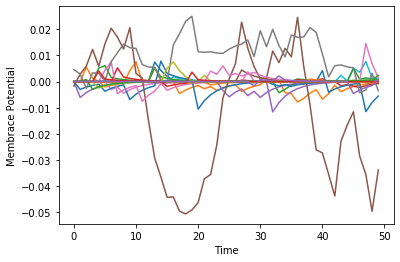

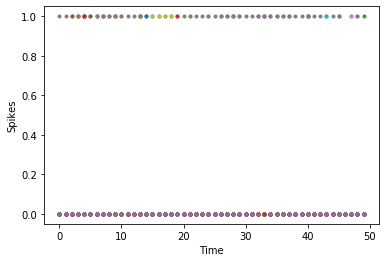

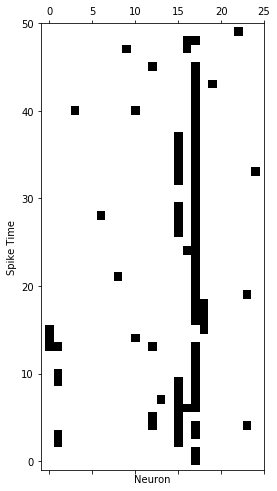

<Figure size 2160x1440 with 0 Axes>

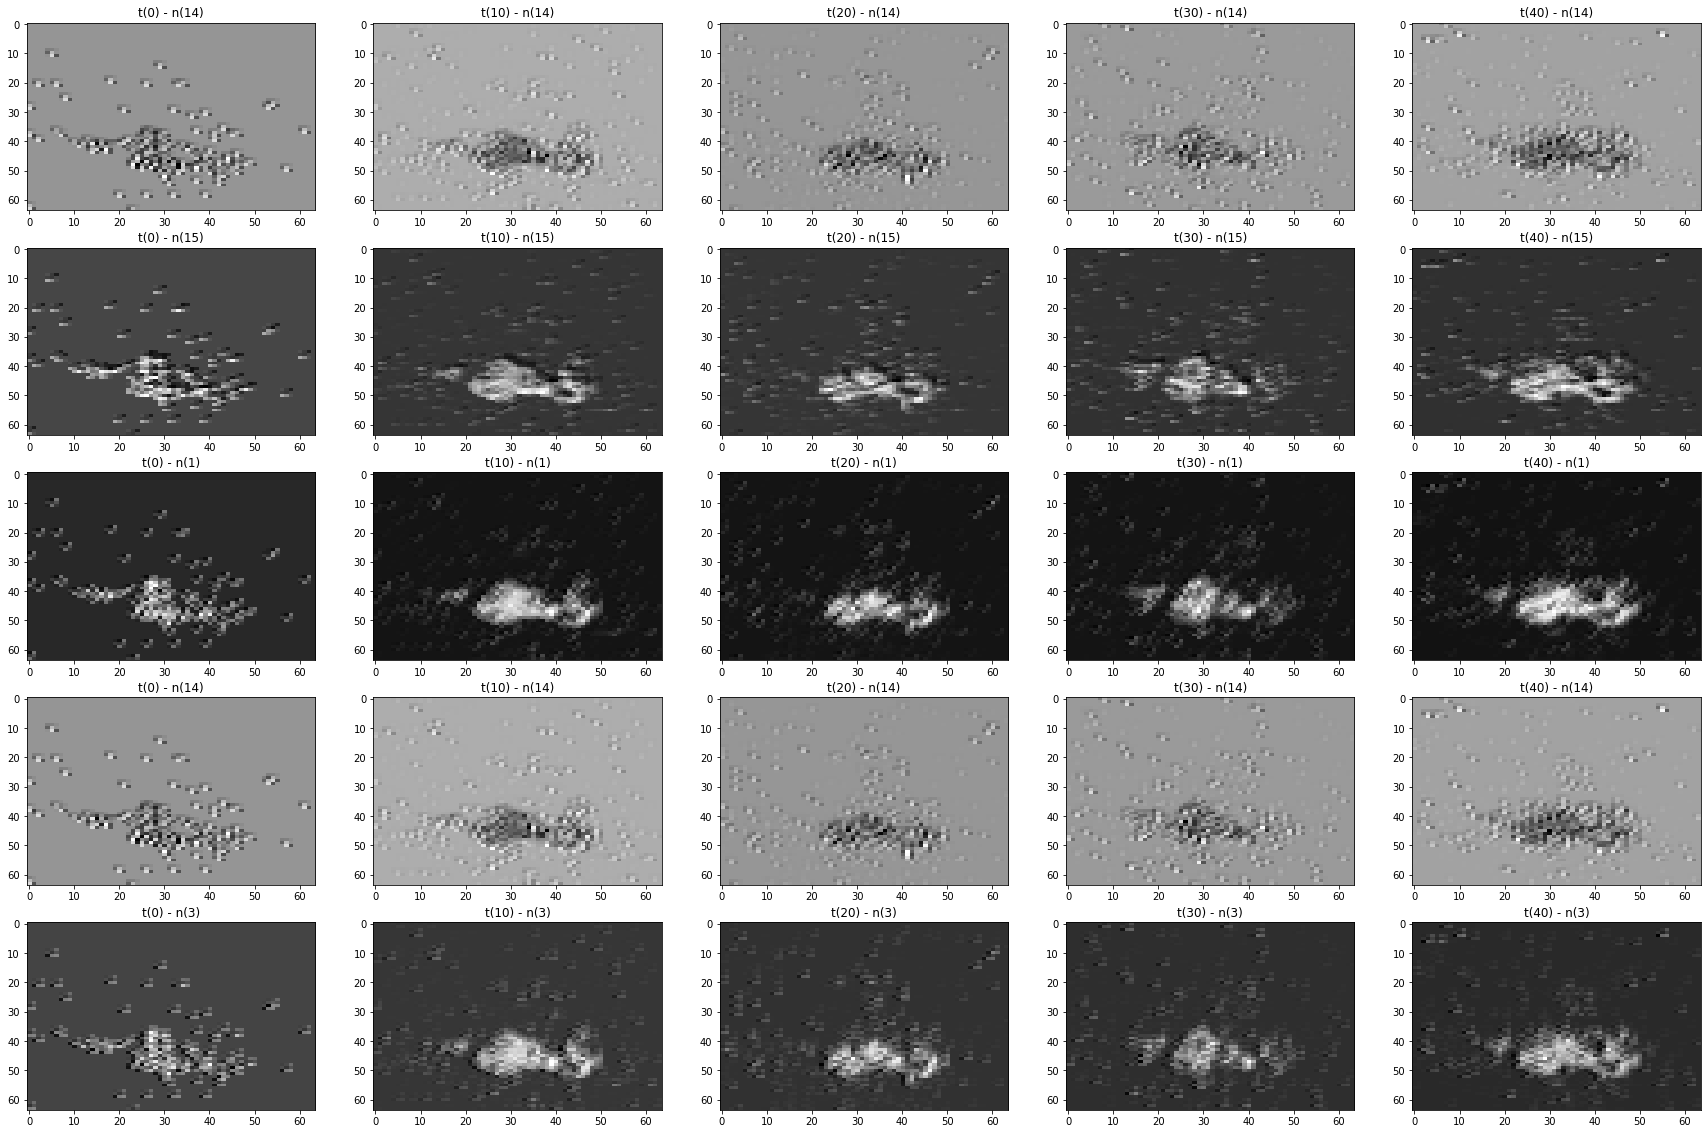

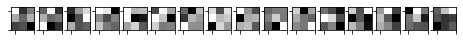

Layer 2: average number of spikes=0.4624
Layer 3: average number of spikes=0.4836


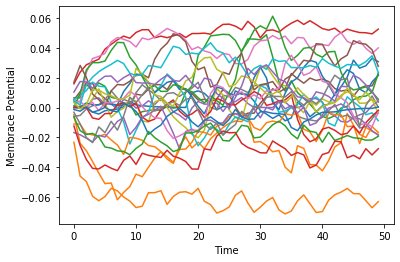

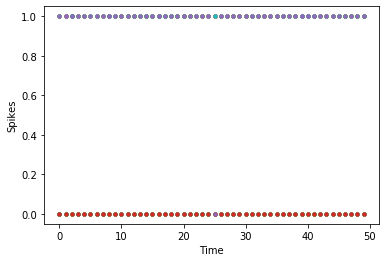

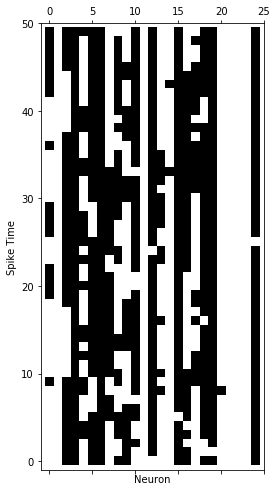

<Figure size 2160x1440 with 0 Axes>

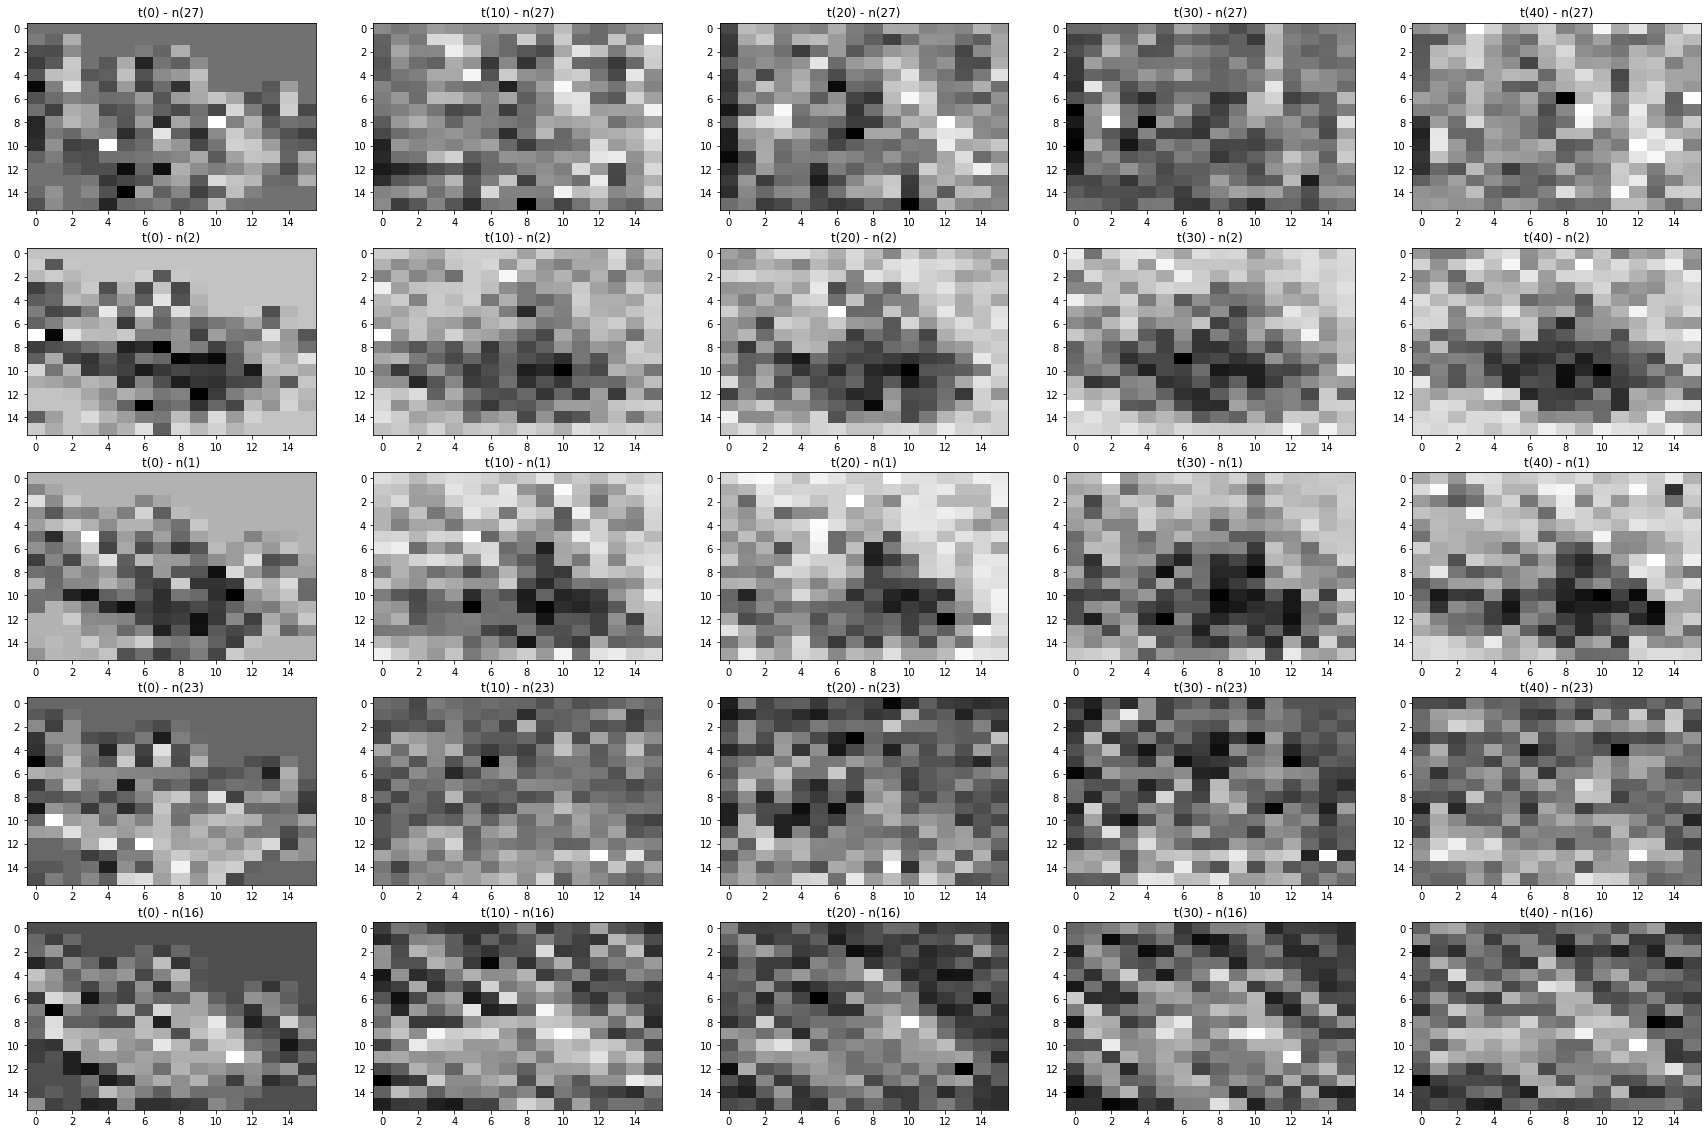

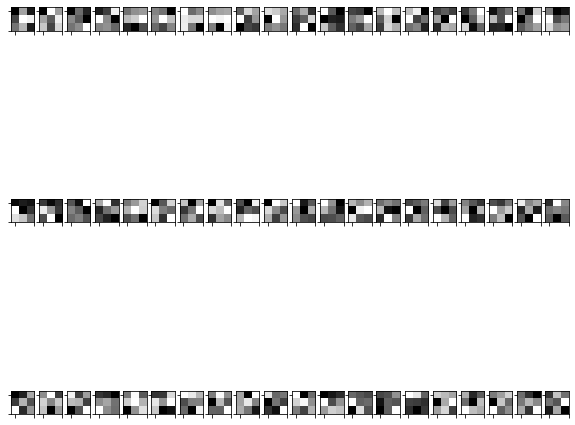

Layer 4: average number of spikes=0.8322


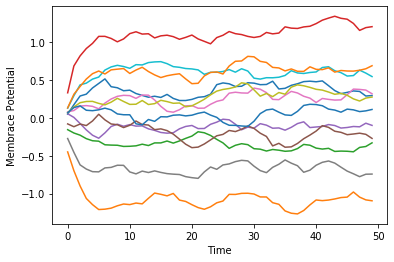

In [50]:
%matplotlib inline

network = SNN(device=device, dtype=dtype, stream_network=True)
network.time_expector = time_expector
network.network.cute_print = True
# network.notifier = notify # FIXME

network.add_conv2d(
    input_shape=(64,64),
    
    output_channels=16,
    kernel_size=(3,3),
    dilation=(1,1),
    lateral_connections=False,
    recurrent=False,
    
    w_init_mean=0.00,
    w_init_std=0.05
)
network.add_pool2d(kernel_size=(4,4))


network.add_conv2d(
    output_channels=32,
    kernel_size=(3,3),
    dilation=(1,1),
    lateral_connections=False,
    recurrent=False,
    
    w_init_mean=0.00,
    w_init_std=0.05
)
network.add_pool2d(kernel_size=(4,4))


# network.add_conv3d(    
#     output_channels=128,
#     kernel_size=(1,3,3),
#     dilation=(1,1,1),
#     lateral_connections=False,
#     recurrent=False,
    
#     w_init_mean=0.00,
#     w_init_std=0.05
# )
# network.add_pool2d(kernel_size=(2,2))

# network.add_conv3d(    
#     output_channels=256,
#     kernel_size=(1,3,3),
#     dilation=(1,1,1),
#     lateral_connections=False,
#     recurrent=False,
    
#     w_init_mean=0.00,
#     w_init_std=0.05
# )
# network.add_pool2d(kernel_size=(2,2))


# network.add_layer(DenseStream,#_dense(
#     output_shape=128,
#     w_init_mean=0.0,
#     w_init_std=0.8
# #     lateral_connections=True
# )

network.add_readout(
    output_shape=12,
#     time_reduction="mean",

    w_init_mean=0.0,
    w_init_std=0.6
)

network.compile()

print('Network Summery:', network.serialize_to_text())
plot_one_batch(network)

pre-processing dataset: 200
pre-processing dataset: 201
Epoch: 1 [🚁    🌨       🌨      🌦        🌨 ] 100%                                   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  2.2756 |  2.3387 |  36.41% |  23.55% |

Epoch: 2 [🛸    ⛅️       ⛅️      ⛈        ] 100%                                   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  1.7127 |  3.1841 |  40.41% |  26.77% |

Epoch: 3 [🚗    🏚       🏚      🕍        🏚 ] 100%                                   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  1.4170 |  2.5440 |  55.19% |  29.17% |



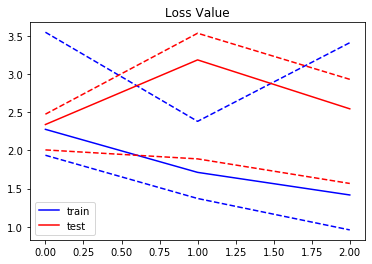

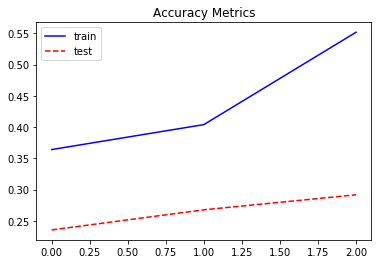

In [54]:

lr=0.001
opt = RAdam(network.get_trainable_parameters(lr))
#     opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
res_metrics = network.fit(
    load_data, 
    epochs=3,
    optimizer=opt, 
    save_checkpoints=False
)
plot_metrics(res_metrics)
# plot_one_batch(network)

Layer 1: average number of spikes=0.1043


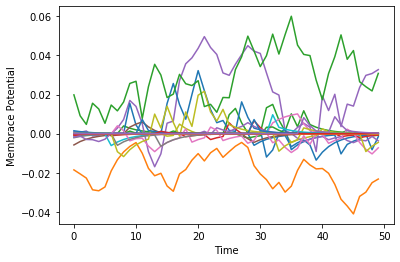

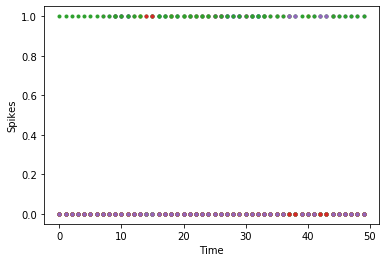

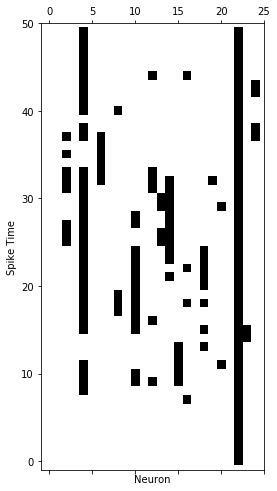

<Figure size 2160x1440 with 0 Axes>

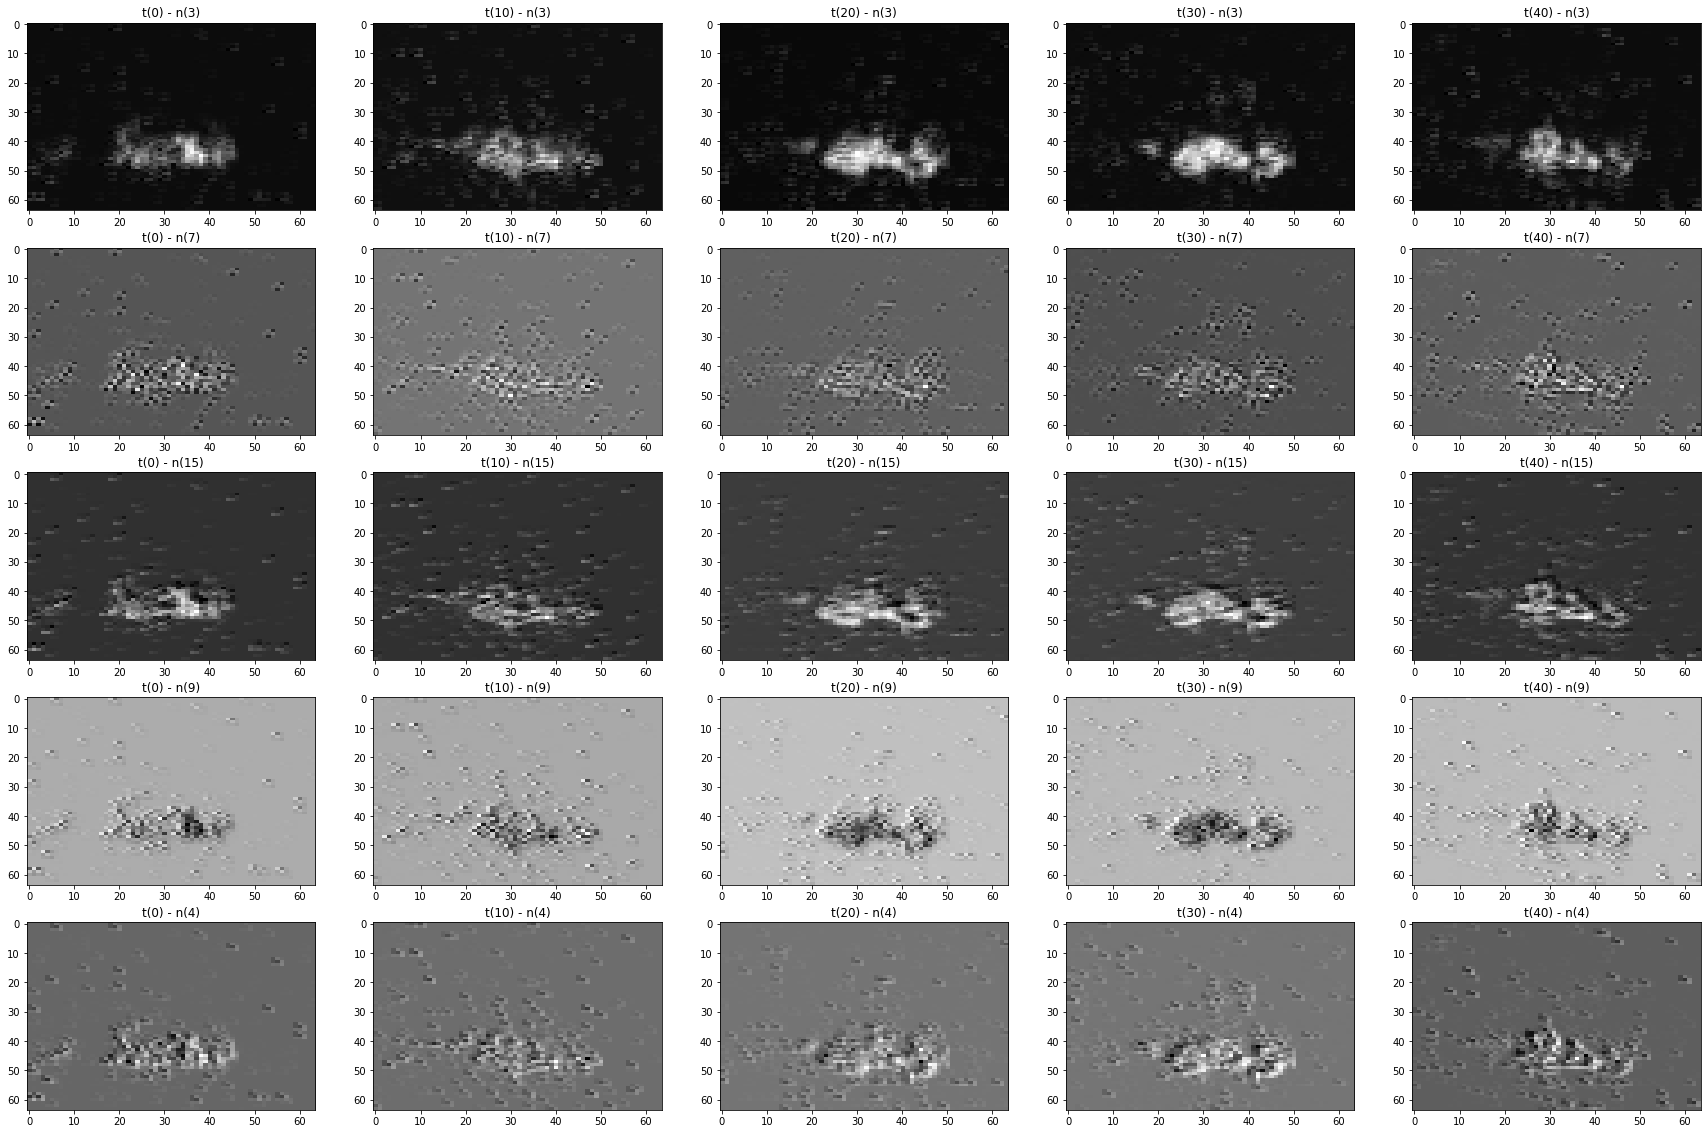

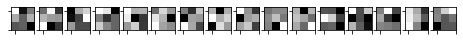

Layer 2: average number of spikes=0.4129
Layer 3: average number of spikes=0.1368


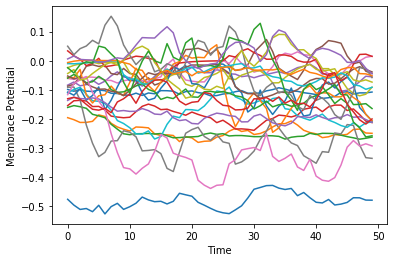

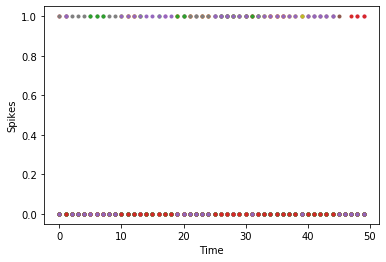

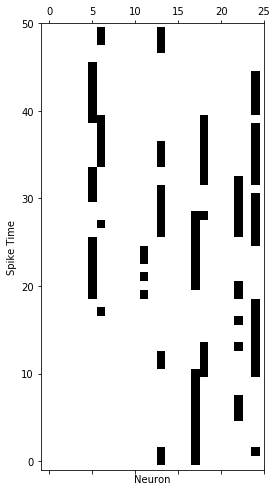

<Figure size 2160x1440 with 0 Axes>

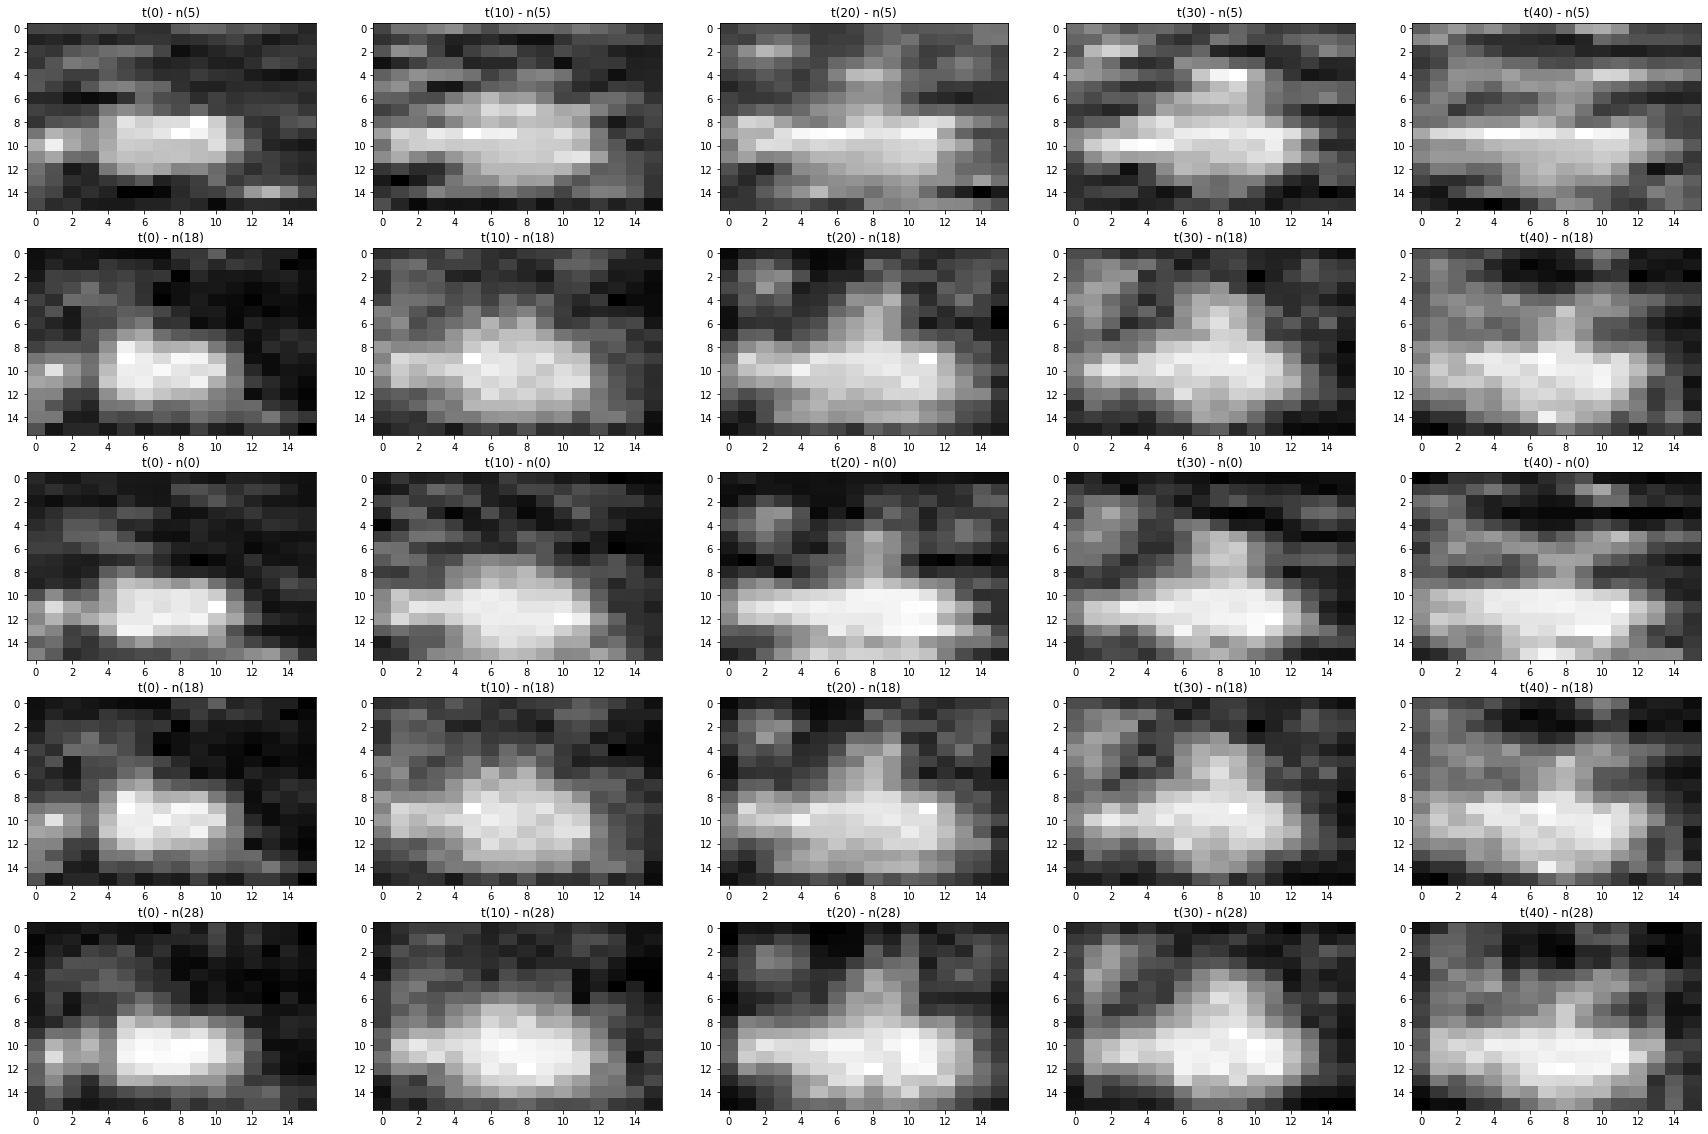

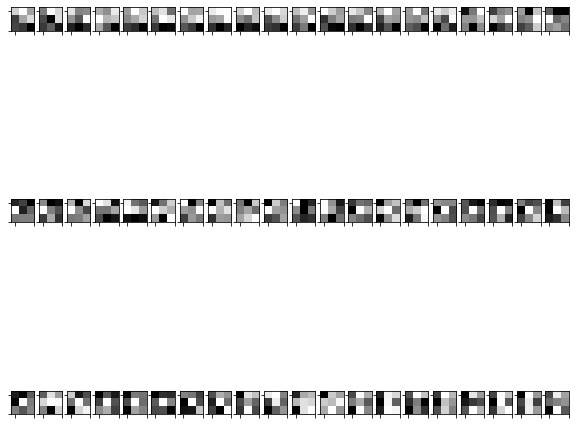

Layer 4: average number of spikes=0.3388


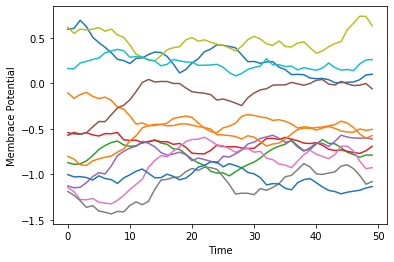

In [55]:
plot_one_batch(network)

In [ ]:
%matplotlib osx

plt.ion()

def plot_one_batch_animate(network, batch_id=0):
#     network.network.reset_mem(BATCH_SIZE)
    batch_size = network.network.layers[1].mem.shape[0]
    for l in network.network.layers:
        l.reset_mem(batch_size, network.network.device, network.network.dtype)


    gs = GridSpec(2, 2)
    plt.figure(figsize=(10, 10))

    __img = None #np.zeros((64, 64))
    ax_image   = plt.subplot(gs[0])
    ax_readout = plt.subplot(gs[1])
    
    counter = 0
    for xb, yb in load_data('train'):
        ax_image.clear()
        ax_readout.clear()
        
        yhat = network.network.predict(xb)
        print('yhat.shape:', yhat.shape)
        print('         - ', yhat)
        yhat_max = torch.argmax(yhat, 1).numpy()
        
        mem_rec_hist = network.layers[-1].mem_rec_hist[batch_id]
        for i in range(mem_rec_hist.shape[1]):
            ax_readout.plot(mem_rec_hist[:, i], label='mem')
            if i > 30:
                break
        ax_readout.set_xlabel('Time')
        ax_readout.set_ylabel('Membrace Potential')
        ax_readout.set_title('Frame: %d' % counter)
        
#         print('yhat_max', yhat_max[0])
#         print('xb.shape=', xb.shape)
#         print('yb.shape=', yb.shape)
#         print('yhat.shp=', yhat.shape)
        
        # Draw Image
        if __img is None:
            __img = xb[batch_id, :, :] * .5
        __img = __img * 0.9 + xb[batch_id, :, :] * 0.13
        ax_image.imshow(__img, cmap='gray', vmin=0, vmax=1)
        ax_image.set_title('%s - %s' % (GESTURE_MAPPING[yhat_max[0]], GESTURE_MAPPING[yb[0]]))
        
#         ax_image.draw()
        plt.pause(0.00001)
        
        counter += 1
        if counter == 500:
            break

#     for i,l in enumerate(network.layers):
#         if 'spk_rec_hist' in l.__dict__:
#             print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
#         plot_spikes_in_time(l, batch_id)

plot_one_batch_animate(network)